## Pendulum: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [5]:
model = 'pendulum'

### Cost function

Create `Kphiphi` to find the regularizer `R`

In [6]:
# Create Kphiphi
X = x_train_all.flatten()
sigma_K = jnp.array([0.14840741, 0.88888889, 0.88888889])
Kphiphis = [Kphiphi_assembly( X[i*e:(i+1)*e] , k = 'Gaussian', k_param = sigma_K[i]) for i in range(3)]

In [7]:
# # Tr(Kphiphi)
# trK = jnp.trace(Kphiphi[0:e,0:e])
# # Tr(D^1D^1 Kphiphi)
# trDDK = jnp.trace(Kphiphi[e:2*e,e:2*e])
# # Tr(D^2D^2 Kphiphi)
# trD2D2K = jnp.trace(Kphiphi[2*e:3*e,2*e:3*e])
# # First block
# ones = jnp.ones((e))
# # Second block
# second = ones*trDDK/trK
# # Third block
# third = ones*trD2D2K/trK
# # Assemble R or take the diagonal or Kphiphi
# diagonal = jnp.concatenate((ones,second,third))
# R = jnp.diag(diagonal)

Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(3)]

Create objective function `L`

In [34]:
def L(Z, X, U, f, Kphiphis, Rs, lmbd):
    """Cost function for one step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrix that regularizes Kphiphi
    Returns:
        scalar: a cost of this solution.    
    """ 
   
    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N)
    sigma_Gamma = 0.8152747082066607 # From 2-step - ADD THEM TO THE DATA LOADER !!!
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    alpha_Gamma = 1e-7 # nugget from 2-step !!!
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    rkhs_P = 4038.8546192430285
    L1 = jnp.dot(f.T , b) / rkhs_P
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    #sigma_K = jnp.mean(jnp.array([0.24994344, 0.74908123, 0.74908123])) # From 2-step
    #Kphiphi = Kphiphi_assembly( X[:e] , k = 'Gaussian',k_param = sigma_K)
    alpha_K = 1e-6
    Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(3)] 
    #print("cond(Kphiphis) = ", jnp.linalg.cond(Kphiphis))

    rkhss = [1.1833129190245972, 10.115269194432372, 136.2124679543351]
    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[e*i:e*(i+1),:].T,(e*3,1)) # DOUBLE CHECK THE ORDER HERE
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i] # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        #print("L2_{} = ".format(i),jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i])
    # Keep track of the RKHSs norms here, specially of the exponential
    # Compute the total loss per epoch
    # Compute the loss per function u epoch 
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

- Check the order of the two terms in the loss

#### Gradient descent

Training data

In [35]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(e*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [36]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(e*m,1),u_xx_pred_train.T.reshape(e*m,1)])

In [37]:
L(Z_warm, X, U, f, Kphiphis, Rs, lmbd = 1/3)

Array(1.9999881, dtype=float64)

Which `lmbd` in the expression `L1 + lmbd*L2` should I use if `L1` >> `L2` ?

In [38]:
lmbd_min = 1/3 # It always picks the smallest here 

Initialize the grad functions with `jit` to be efficient

In [39]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, f, Kphiphis, Rs,lmbd= lmbd_min)
# Warm start here !!!

Array([[-0.03153047, -0.00708913],
       [-0.07287239, -0.0031152 ],
       [-0.08243508, -0.01732677],
       [-0.13644785, -0.00760032],
       [ 0.01092829,  0.01865299],
       [ 0.36908927,  0.03861299],
       [-0.01584958, -0.00340532],
       [ 0.02673529,  0.01415693],
       [ 0.02252488, -0.00414139]], dtype=float64)

Run the gradient descent for `100` epochs

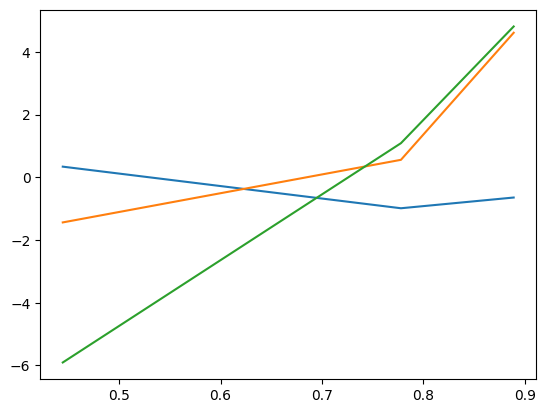

In [40]:
# Sanity check here!
plt.plot(x_train[0:e], U[0:e])
plt.plot(x_train[0:e], u_x_pred_train[0:e,0])
plt.plot(x_train[0:e], u_x_train[:,0])
plt.show()

### Gradient descent

In [68]:
# Only do this for the first time - 
Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

In [69]:
# If trained previously use Z
if np.all(Z != Z_warm):
    Z = np.load('data/Z.npy')
else:
    Z = np.copy(Z_warm)
learning_rate = 1e-4
for i in range(40000):
    delta_Z = grad_Z(Z, X, U, f, Kphiphis, Rs, lmbd=lmbd_min)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    if i % 10 == 0:
        print(L(Z, X, U, f, Kphiphis, Rs, lmbd=lmbd_min))
        # Load true gradients from 2-step
        u_x_train = np.load('data/u_x_train.npy')
        u_xx_train = np.load('data/u_xx_train.npy')
        # Build true Z
        Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])
    # if i == 0:
    #     fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
    #     ax1.set_title(r'$\partial_x$ sine')
    #     ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
    #     ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
    #     ax1.legend()
    #     ax2.set_title(r'$\partial_{xx} sine$')
    #     ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
    #     ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
    #     ax2.legend()
    #     ax3.set_title(r'$\partial_x$ poly')
    #     ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
    #     ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
    #     ax3.legend()
    #     ax4.set_title(r'$\partial_{xx}$ poly')
    #     ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
    #     ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
    #     ax4.legend()
    #     ax5.set_title(r'$\partial_x$ exp')
    #     ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
    #     ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
    #     ax5.legend()
    #     ax6.set_title(r'$\partial_{xx}$ exp')
    #     ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
    #     ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
    #     ax6.legend()
    #     plt.show()
        
# Save at the end of iterations
np.save('data/Z.npy',Z)

2.5148674682905074
2.504543317212514
2.5029243948290194
2.502079636388358
2.5015344091069203
2.5011761330327427


2.500939863761728
2.5007835107532
2.5006795390295067
2.500609916259159
2.5005628287083392
2.5005305343346698
2.5005079579609983
2.5004917716397
2.500479792443254
2.5004705880092586
2.5004632181010598
2.5004570652424407
2.5004517236998036
2.5004469266917733
2.5004424986524616
2.5004383239154047
2.5004343261653337
2.5004304549498224
2.50042667682382
2.500422969532589
2.500419318189254
2.5004157127631332
2.500412146427137
2.500408614470168
2.5004051135820906
2.500401641381895
2.50039819610653
2.5003947764066976
2.5003913812103225
2.50038800963393
2.5003846609226863
2.500381334411591
2.5003780294987856
2.500374745628529
2.500371482279442
2.5003682389565824
2.5003650151862935
2.5003618105122487
2.5003586244934137
2.5003554567021364
2.5003523067225846
2.500349174150216
2.500346058591025
2.500342959660883
2.500339876985399
2.500336810198966
2.5003337589452452
2.5003307228761105
2.5003277016521315
2.5003246949417175
2.5003217024214512
2.5003187237754902
2.500315758695554
2.500312806880877
2.50

## Evaluation of `Z`

In [50]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])

> One-step Method vs Truth (GOAL HERE IS P)

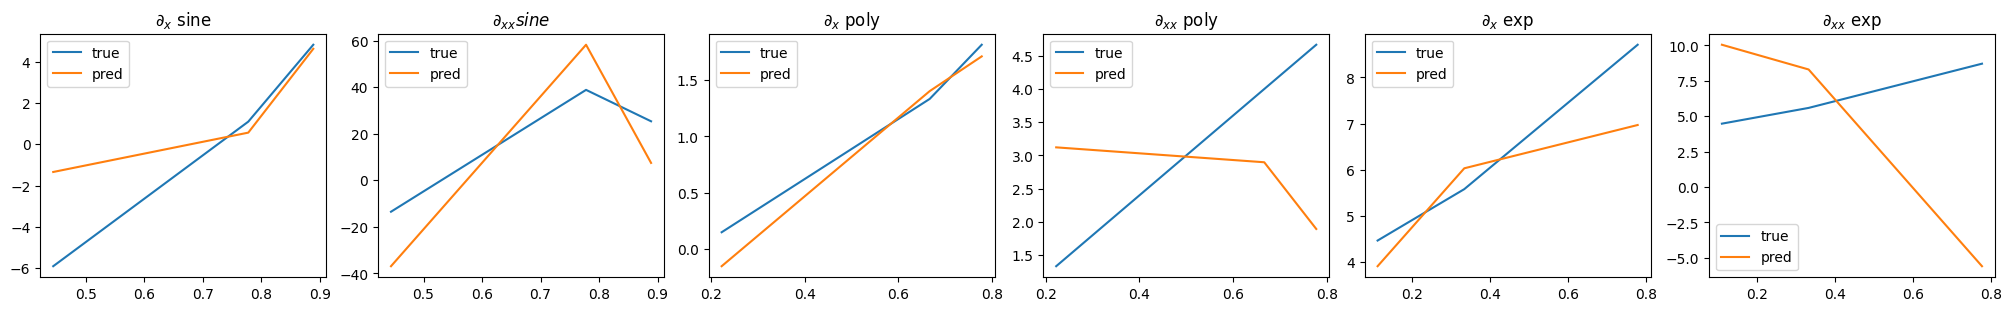

In [62]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

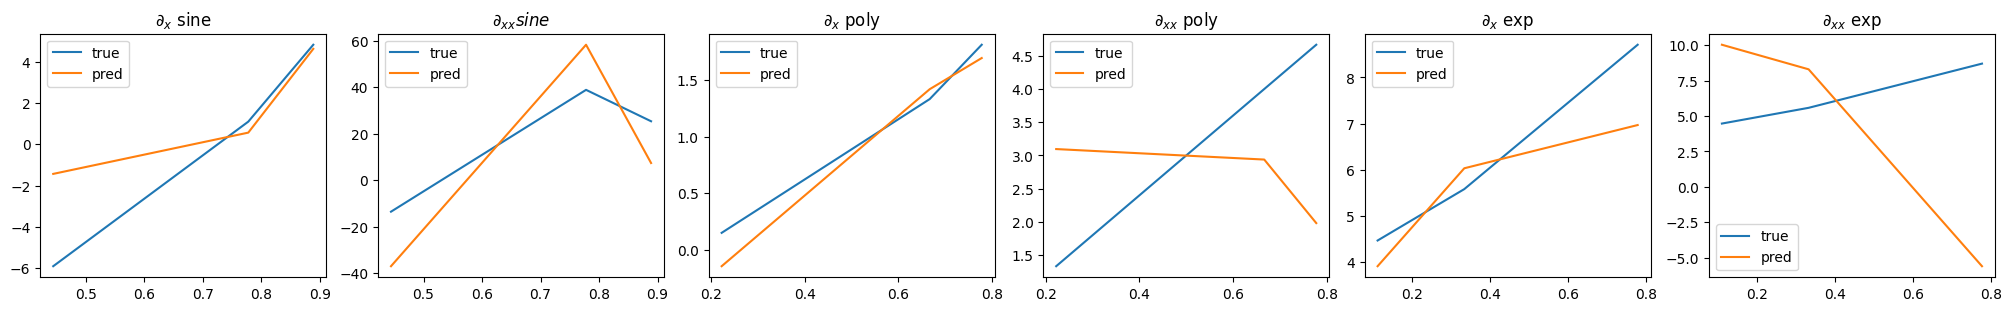

In [52]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z_warm[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z_warm[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z_warm[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z_warm[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()